# vta MC2: Fourier Transformation


## Voraussetzungen


In [1]:
%pip install numpy matplotlib scipy librosa soundfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 60.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 44.0 MB/s eta 0:00:00
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23706 sha256=6145e2e1b44cfe9b2a919f1ad42e434d6e165d61e17b0f1078ac6166b40d3b1b
  Stored in directory: /root/.cache/pip/wheels/da/4b/39/c5f6c4ee93b43281dda4dab5ac5f2bdf9d11074d427493cd55
Successfully built audioread

[notice] A new releas

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# FFT
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq

# Sunspots handling
from scipy.signal import find_peaks

# Audio handling
from IPython.display import Audio 
import soundfile as sf
import librosa
import librosa.display

# Image handling
import matplotlib.image as mpimg
from scipy.fft import fft2, ifft2

# Plot config
%matplotlib inline
plt.rcParams ['figure.figsize'] = [14, 5]
# %config InlineBackend.figure_format = 'retina'  # for better quality plots

## Aufgabe 1

In dieser Aufgabe implementieren Sie die Berechnung der Fourier-Approximation in numpy (kein fft).


**(a)** Implementieren Sie mit numpy eine Methode zur Berechnung der $k$-ten Fourier-Komponente einer Funktion, gegeben durch Arrays $x$ und $y$, mithilfe der Trapezregel (`np.trapz`).


$${\displaystyle c_{n}={\frac {1}{P}}\int _{-P/2}^{P/2}s(x)e^{-{\frac {2\pi inx}{P}}}\,dx\qquad {\text{for all integers}}~n}$$


In [3]:
def fourier_coefficient(x, y, k, P):
    return (1 / P) * np.trapz(y * np.exp(-1j * 2 * np.pi * k * x / P), x)

**(b)** Implementieren Sie mit numpy eine Methode zur Berechnung der Fourier-Approximation $f_{app}$ mit einer gegebenen Anzahl ($2m + 1$) von Fourier-Komponenten.


$${\displaystyle s(x)=\sum _{n=-\infty }^{\infty }c_{n}\cdot e^{\frac {2\pi inx}{P}}}$$


In [4]:
def fourier_approximation(f, a, N, m):
    if a <= 0:
        raise Exception("'a' must be positive")

    x = np.linspace(-a, a, N)
    y = f(x)

    P = 2 * a
    f_coeff = np.array(
        [
            fourier_coefficient(x, y, k, P)
            for k in range(-m, m + 1)
        ]
    )

    f_approx = np.sum(
        [
            f_coeff[k] * np.exp((1j * 2 * np.pi * (k - m) * x) / P)
            for k in range(2*m + 1)
        ], 
        axis=0
    )

    return x, y, f_approx.real, f_coeff.real

**(c)** Nähern Sie die Funktion $f_1(x) = \frac{1}{{e^x + e^{-x}}}$ auf dem Intervall $[-3, 3]$ (Auflösung: $N = 600$ Schritte) mit verschiedenen Anzahlen von Komponenten $2m + 1$. Plotten Sie den Vergleich zur Originalfunktion $f$.


$$
\delta=\left|\frac{v_A-v_E}{v_E}\right|
$$

$$
\mathrm{RE}=\frac{\left\|f(x)-F_n(x)\right\|}{\|f(x)\|}
$$


In [5]:
def compute_rrmse(y, f_app, x_vals):
    assert y.shape == f_app.shape, "Arrays must be the same shape."

    ssq = (y - f_app)**2
    
    if x_vals:
        mse = np.trapz(ssq, x_vals)
    else:
        mse = np.sum(ssq)
    
    rmse = np.sqrt(mse)
    rrmse = rmse / (y.max() - y.min())

    return rrmse

def compute_rrmse_legacy(y, f_app):
    ## https://hal-enpc.archives-ouvertes.fr/hal-03038092/file/fml2b_rev0920.pdf
    ## https://www.analyticsvidhya.com/blog/2021/10/evaluation-metric-for-regression-models/

    # Ensure the arrays are the same size
    assert y.shape == f_app.shape, "Arrays must be the same shape."

    # Compute MSE
    ssqm = np.mean((y - f_app)**2)

    mean = np.mean(y)

    ssqy_error = np.sum((y-mean)**2)

    # Compute RRMSE
    rrmse = np.sqrt(ssqm / ssqy_error)
    return rrmse

def compute_linalg_norm_error(y, f_app):
    return np.linalg.norm(y - f_app) / np.linalg.norm(y)

def rel_error(y, f_app, x_vals=None):
    #return compute_rrmse(y, f_app, x_vals)
    #return compute_rrmse_legacy(y, f_app)
    return compute_linalg_norm_error(y, f_app)

In [6]:
def plot_fourier_approx_and_err(f, a, N, m_values, calc_error=False, err_thresh=.001):
    errors = []
    for i, m in enumerate(m_values):
        x, y, f_app, f_coeff = fourier_approximation(f=f, a=a, N=N, m=m)

        label_str = f"m = {m}"
        if calc_error:
            error = rel_error(y, f_app, x)
            errors.append(error)
            
            label_str += f", err = {error:.3f}"

        if i <= 3 or i == len(m_values) - 1:
            plt.plot(x, f_app, label=label_str)

    # Plot the original function
    plt.plot(x, y, label="Original Function")
    plt.title(f"Fourier Approximation (N={N}, a=[{-a},{a}])")
    plt.legend()
    plt.show()

    if calc_error:
        plt.plot(m_values, errors)
        plt.xlabel("Components (m)")
        plt.ylabel("Relative Error")

        #plt.ylim((0, err_thresh + 1e-3))

        plt.axhline(y=err_thresh, color="r", linestyle="--", label=f"{err_thresh*100}%")
        plt.title(f"Relative Error")
        plt.legend()
        plt.show()

        # Print the lowest number of components needed to be lower equal than the err_thresh
        try:
            indices = np.where(np.array(errors) <= err_thresh)[0]
            min_m_value = m_values[indices.min()]
            print(f"The lowest number of components needed to have an error lower or equal than the threshold is: {min_m_value}")
        except ValueError:
            print("No components yield an error lower or equal to the threshold.")

    return errors if calc_error else None


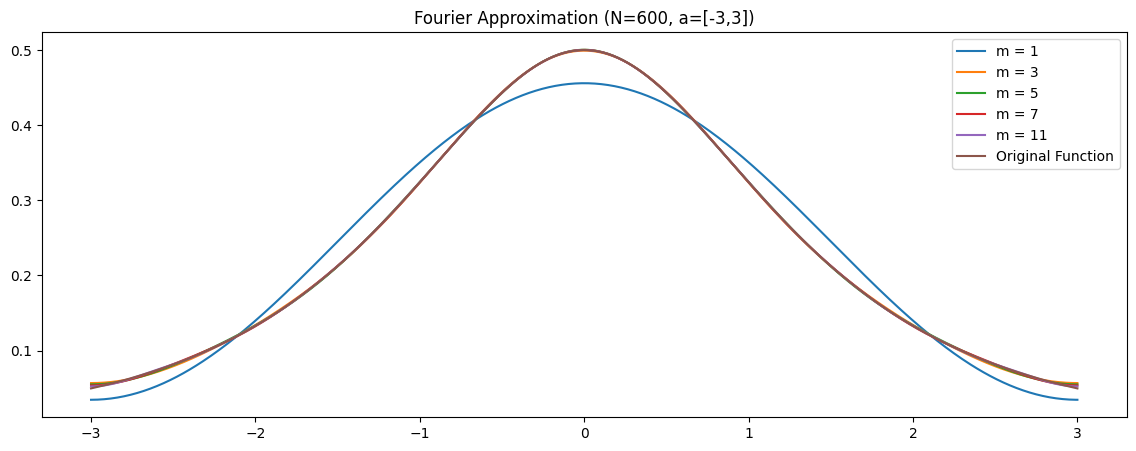

In [7]:
def f1(x):
    return 1 / (np.exp(x) + np.exp(-x))

plot_fourier_approx_and_err(f=f1, a=3, N=600, m_values=[2 * m + 1 for m in range(0, 6)])

**(d)** Bestimmen Sie die Anzahl der Fourier-Komponenten, die benötigt werden, um eine Approximation mit höchstens $0,1$% relativen Fehler zu erhalten.


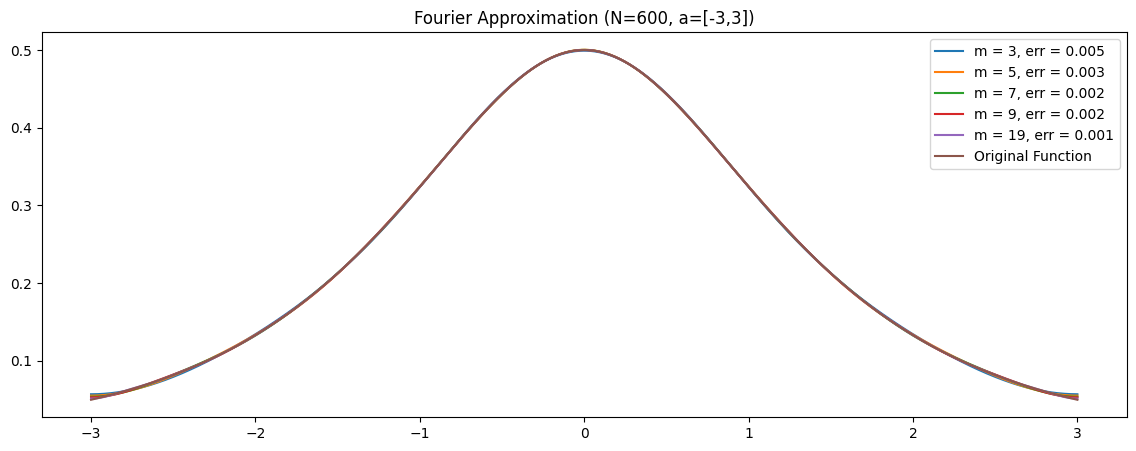

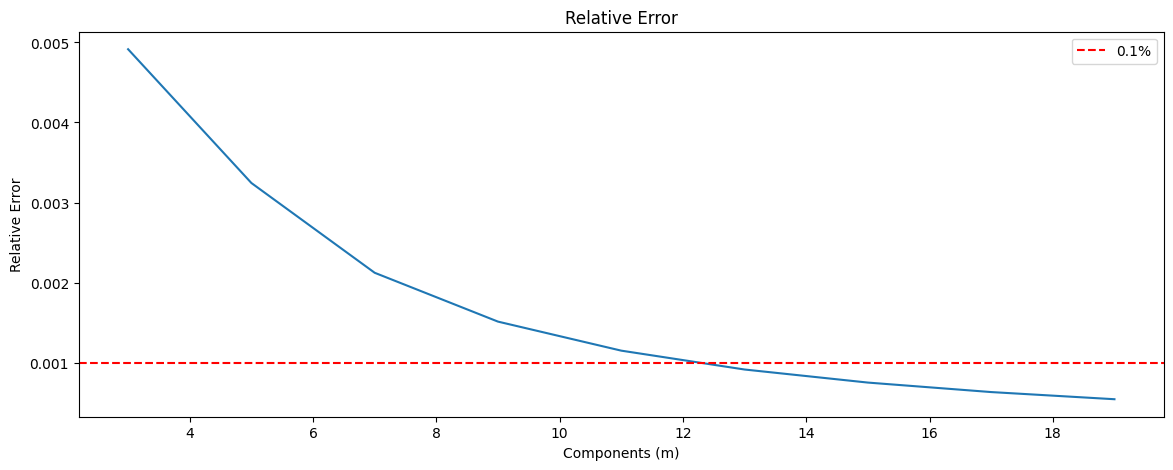

The lowest number of components needed to have an error lower or equal than the threshold is: 13


In [8]:
#m_values = list(range(1, 30))
m_values = [2*m+1 for m in range(1, 10)]

errors = plot_fourier_approx_and_err(f=f1, a=3, N=600, m_values=m_values, calc_error=True)

**(e)** Versuchen Sie die Funktionen $f_2(x) = e^x$ und $f_3(x) = e^{abs(x)}$ auf dem Intervall ($[-3, 3]$) (Auflösung: \(N = 600\) Schritte) mit einem $0,1$%igen Approximationsfehler anzunähern. Beschreiben und erklären Sie die Unterschiede.


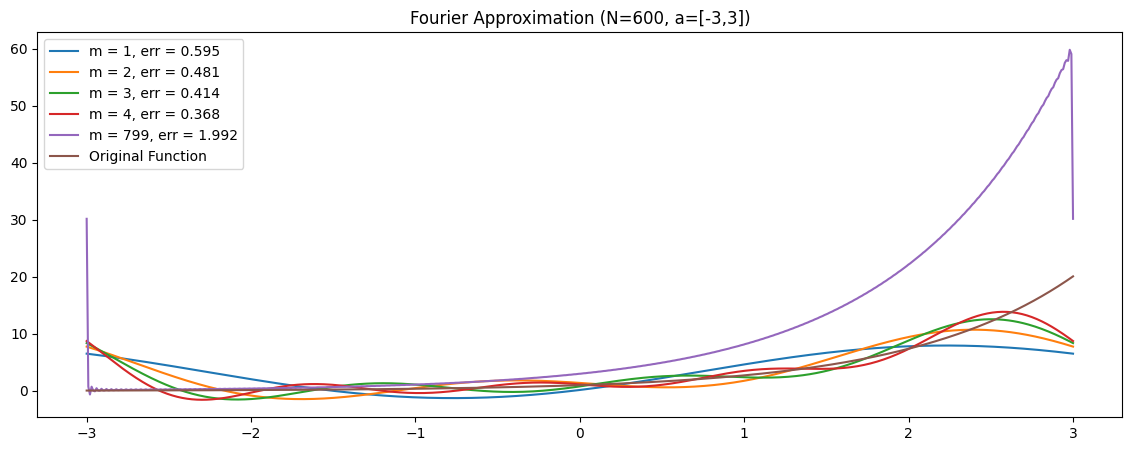

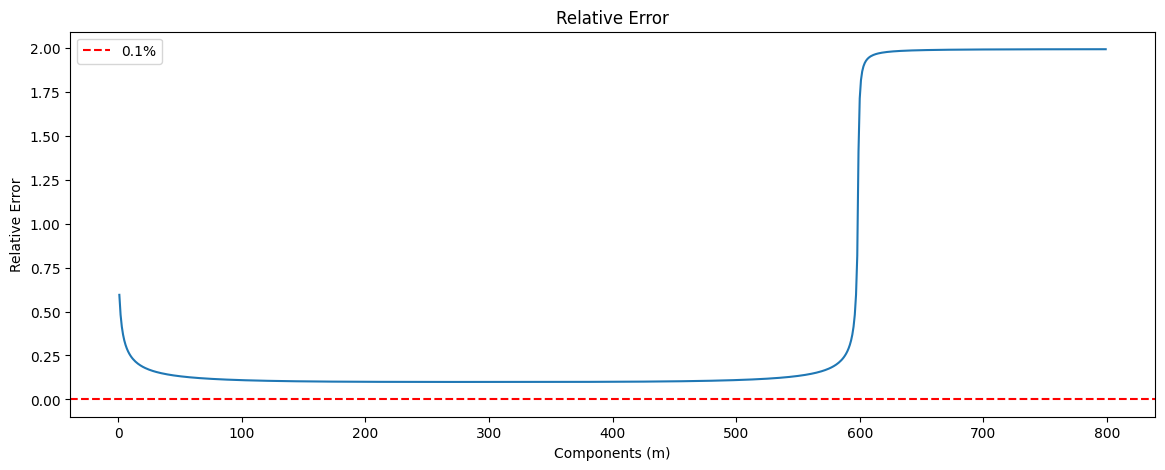

No components yield an error lower or equal to the threshold.


In [9]:
def f2(x):
    return np.exp(x)

errors = plot_fourier_approx_and_err(f=f2, a=3, N=600, m_values=list(range(1, 800)), calc_error=True)

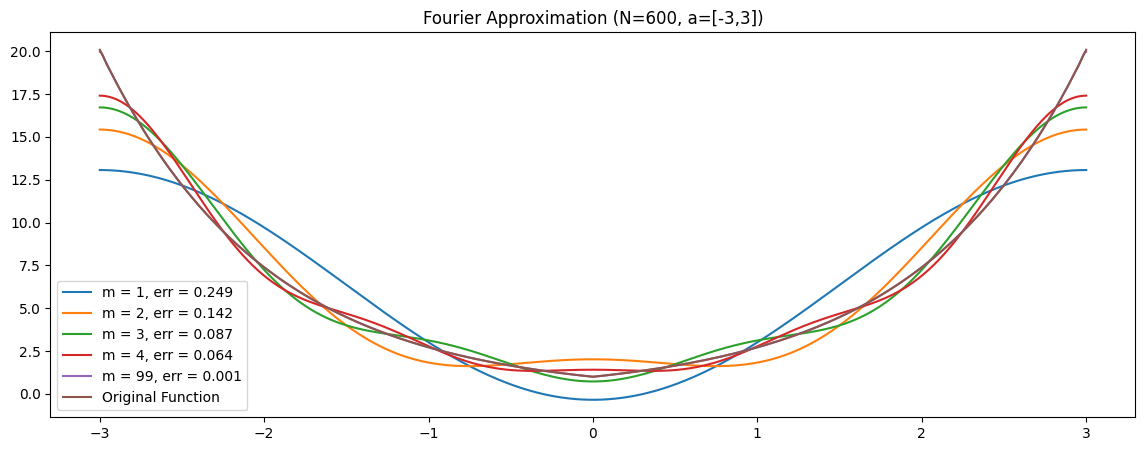

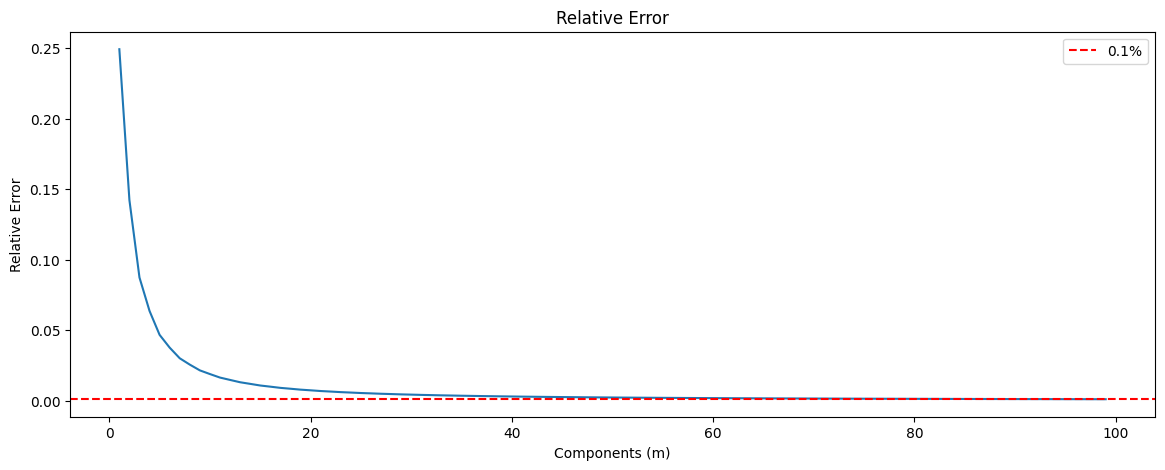

The lowest number of components needed to have an error lower or equal than the threshold is: 93


In [10]:
def f3(x):
    return np.exp(np.abs(x))

errors = plot_fourier_approx_and_err(f=f3, a=3, N=600, m_values=list(range(1, 100)), calc_error=True)

## Aufgabe 2

In dieser Aufgabe wenden Sie die Fourier-Analyse auf Sonnenfleckendaten an (sunspots.txt). Sie
dürfen dafür die fft routine von numpy oder scipy verwenden.

- **(a)** Plotten Sie das Power-Spektrum und finden Sie die dominante Periodizität der Schwingung.
  Damit erhalten Sie eine Abschätzung auf die Dauer des Sonnenzyklus.

- **(b)** Können Sie weitere Perioden in den Sonnenfleck-Daten mithilfe des Fourier-Spektrums
  finden?

- **(c)** Entfernen Sie einige Komponenten im Fourier-Spektrum und führen dann eine Rücktrans-
  formation durch:

  - grössten Komponenten entfernen (k > 20)
  - kleinsten Komponenten entfernen (k < 5)

  Beschreiben und erklären Sie die Ergebnisse.

- **(d)** Vergleichen Sie die Ergebnisse mit denen aus Aufgabe 1. Beschreiben und erklären Sie
  Unterschiede in den Fourier-Koeffizienten.

### (a)

Plotten Sie das Power-Spektrum und finden Sie die dominante Periodizität der Schwingung.

In [11]:
def load_sunspot_data(path="./data/sunspots.txt"):
    sunspot_data = np.loadtxt(path)
    sunspot_data = sunspot_data.reshape(63 * 5, 2)
    recorded_years = sunspot_data[:, 0]
    sunspot_counts = sunspot_data[:, 1]
    print(recorded_years.shape, sunspot_counts.shape)
    return recorded_years, sunspot_counts

recorded_years, sunspot_counts = load_sunspot_data()

(315,) (315,)


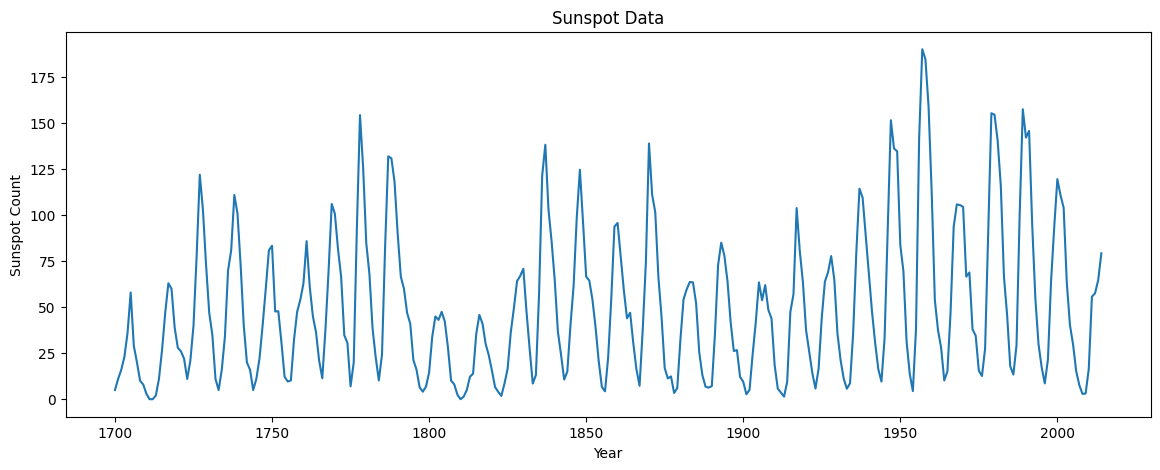

In [12]:
plt.plot(recorded_years, sunspot_counts)
plt.title("Sunspot Data")
plt.xlabel("Year")
plt.ylabel("Sunspot Count")
plt.show()

In [13]:
# Frequency Calculation
num_years = len(recorded_years)
sampling_interval = recorded_years[1] - recorded_years[0]  # Sampling Interval
sampling_rate = 1 / sampling_interval  # Sampling Rate

# Fourier Transformation
fft_values = fft(sunspot_counts)
frequencies = fftfreq(len(sunspot_counts), sampling_rate)

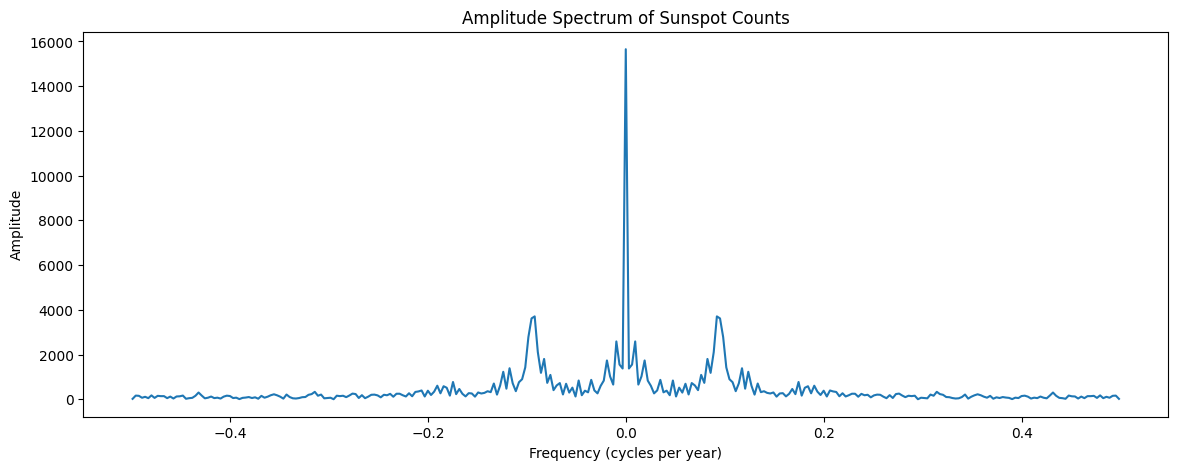

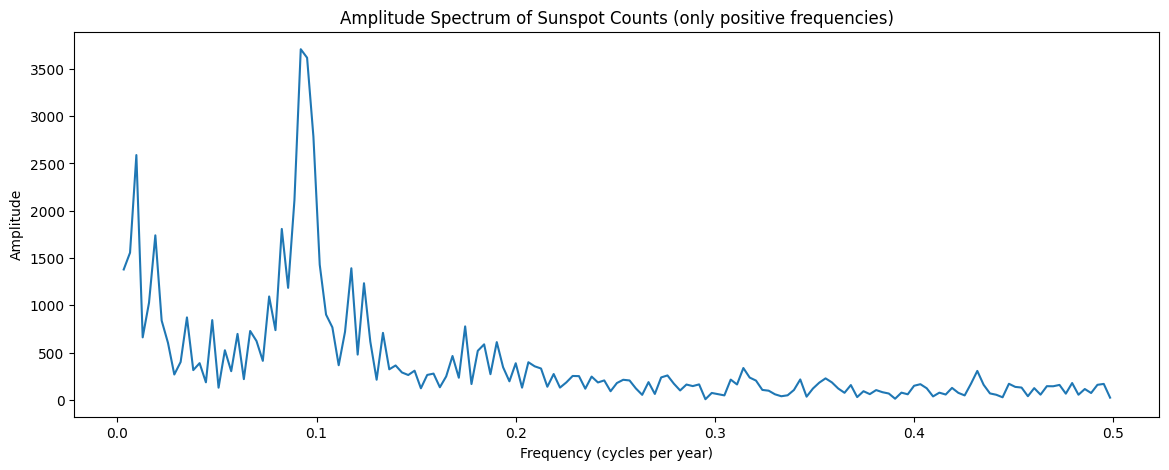

In [14]:
# Plotting Frequencies
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values)))
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Amplitude Spectrum of Sunspot Counts")
plt.show()

# Only Plotting Positive Frequencies
positive_frequencies = frequencies[frequencies > 0]
positive_fft_values = fft_values[frequencies > 0]

# Plotting Frequencies
plt.plot(positive_frequencies, np.abs(positive_fft_values))
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Amplitude Spectrum of Sunspot Counts (only positive frequencies)")
plt.show()

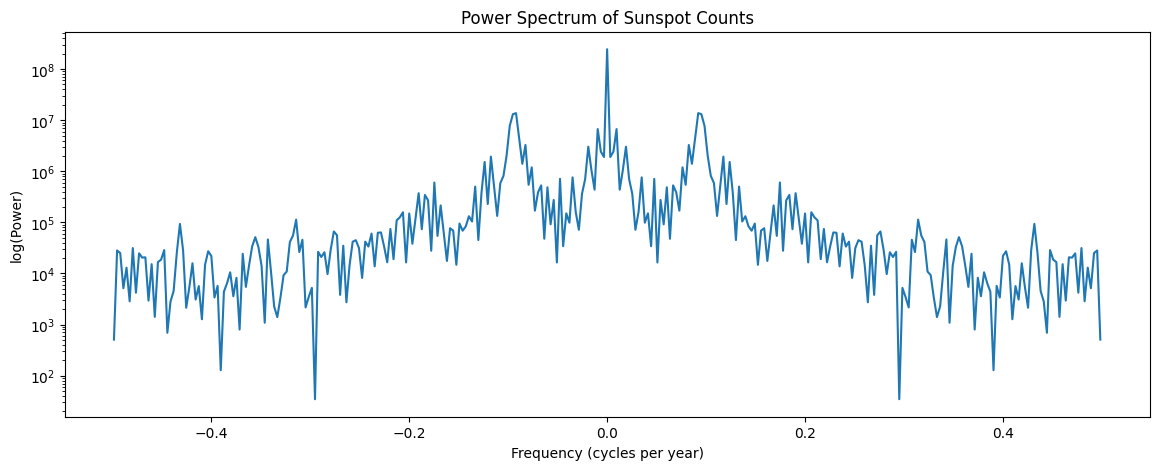

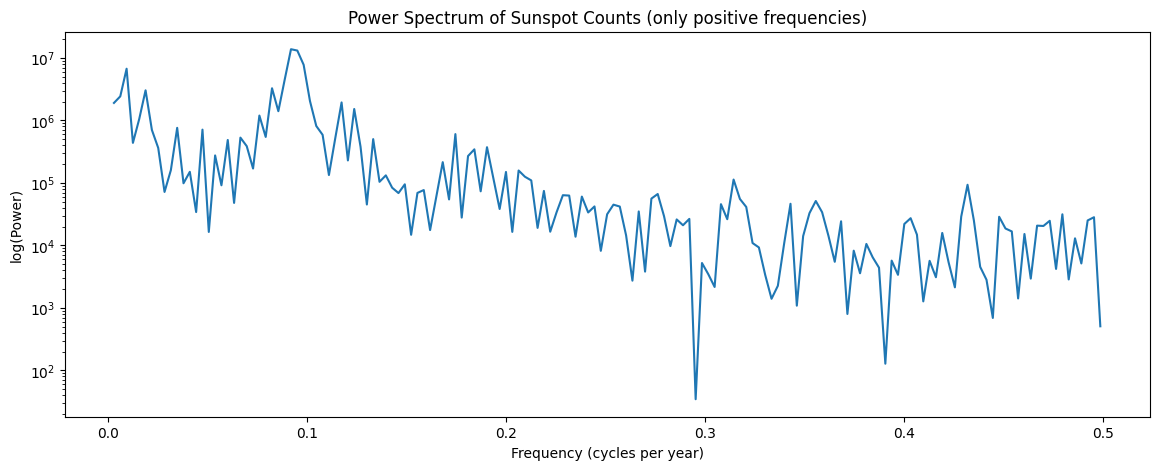

In [15]:
# Plotting Power Spectrum
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values)) ** 2)
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("log(Power)")
plt.title("Power Spectrum of Sunspot Counts")
plt.yscale('log')
plt.show()


plt.plot(positive_frequencies, np.abs(positive_fft_values) ** 2)
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("log(Power)")
plt.title("Power Spectrum of Sunspot Counts (only positive frequencies)")
plt.yscale('log')
plt.show()

In [16]:
peak_frequency = positive_frequencies[np.argmax(np.abs(positive_fft_values))]
print(f"Peak Frequency: {1 / peak_frequency} years")

Peak Frequency: 10.86206896551724 years


### (b) 
Können Sie weitere Perioden in den Sonnenfleck-Daten mithilfe des Fourier-Spektrums
finden?

Dominant frequencies in the spectrum (descending):
1. 10.862 years
2. 105.000 years
3. 12.115 years
4. 52.500 years
5. 8.514 years
6. 8.077 years
7. 13.125 years


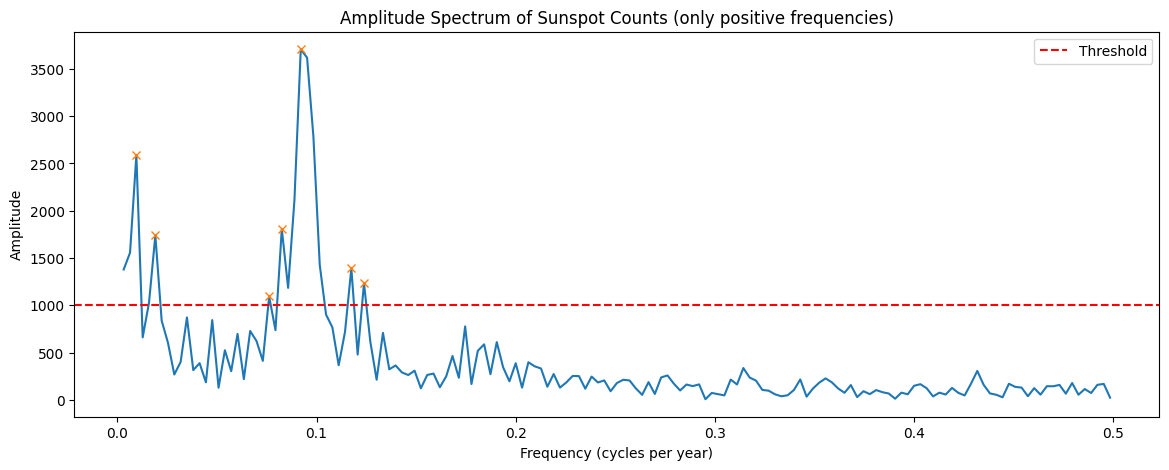

In [17]:
height_threshold = 1e3

# Calculate the absolute values of the FFT results
abs_fft_values = np.abs(positive_fft_values)

# Use scipy's find_peaks function to find the indices of the peaks
peak_indices, _ = find_peaks(abs_fft_values, height=height_threshold)
sorted_peak_indices = peak_indices[np.argsort(abs_fft_values[peak_indices])[::-1]]
sorted_dominant_frequencies = positive_frequencies[sorted_peak_indices]

# Print the frequencies in descending order
print("Dominant frequencies in the spectrum (descending):")
for i, freq in enumerate(sorted_dominant_frequencies, 1):
    print(f"{i}. {1/freq:.3f} years")

plt.figure(figsize=(14, 5))
plt.plot(positive_frequencies, abs_fft_values)
plt.plot(positive_frequencies[peak_indices], abs_fft_values[peak_indices], "x")
plt.axhline(y=height_threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Amplitude Spectrum of Sunspot Counts (only positive frequencies)")
plt.legend()
plt.show()

- https://www.semanticscholar.org/paper/The-~-11-yr-Solar-Cycle-Bacon-Organon/04b1dbf40ac1fccc078b33025c33bc81eea62edd
- https://www.researchgate.net/figure/Power-spectrum-of-the-sunspot-number-fluctuation-The-arrow-indicates-the-peak-at-f-11_fig2_2146547
- https://www.worldscientific.com/doi/10.1142/S0218348X08004009


### (c) 
Entfernen Sie einige Komponenten im Fourier-Spektrum und führen dann eine Rücktransformation durch:
- grössten Komponenten entfernen (k > 20)
- kleinsten Komponenten entfernen (k < 5)
Beschreiben und erklären Sie die Ergebnisse.

In [18]:
filter_below_5 = (np.abs(frequencies) > 1 / 5) | (frequencies == 0) # 5 years k < 5
filter_above_20 = np.abs(frequencies) < 1 / 20 # 20 years k > 20

fft_values_below_5 = fft_values * filter_below_5
fft_values_above_20 = fft_values * filter_above_20

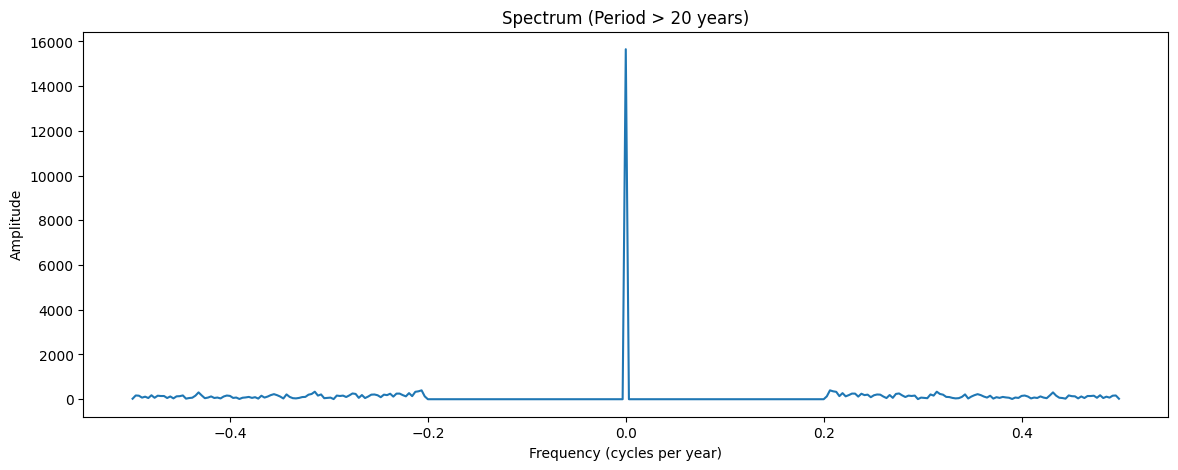

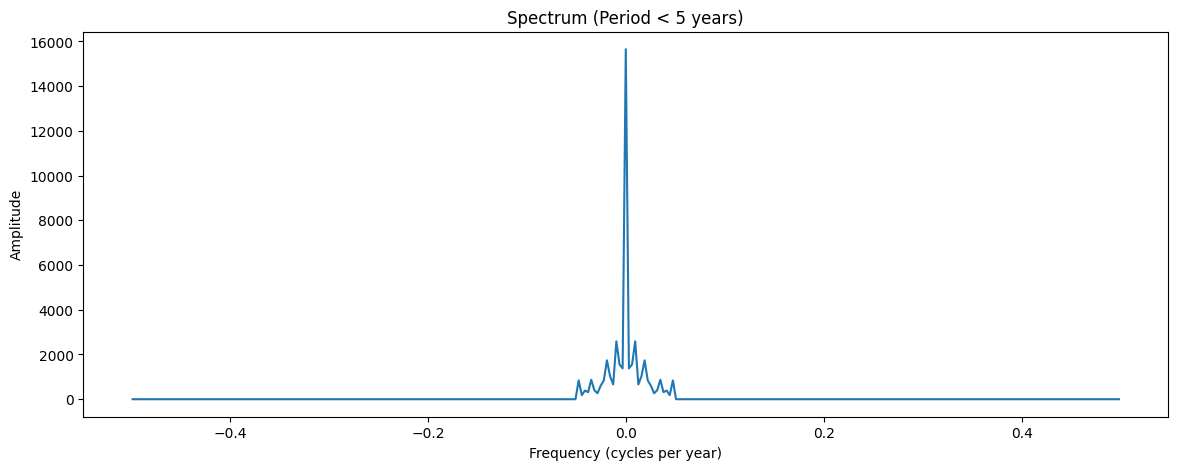

In [19]:
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values_below_5)))
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Spectrum (Period > 20 years)")
plt.show()

plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values_above_20)))
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Spectrum (Period < 5 years)")
plt.show()

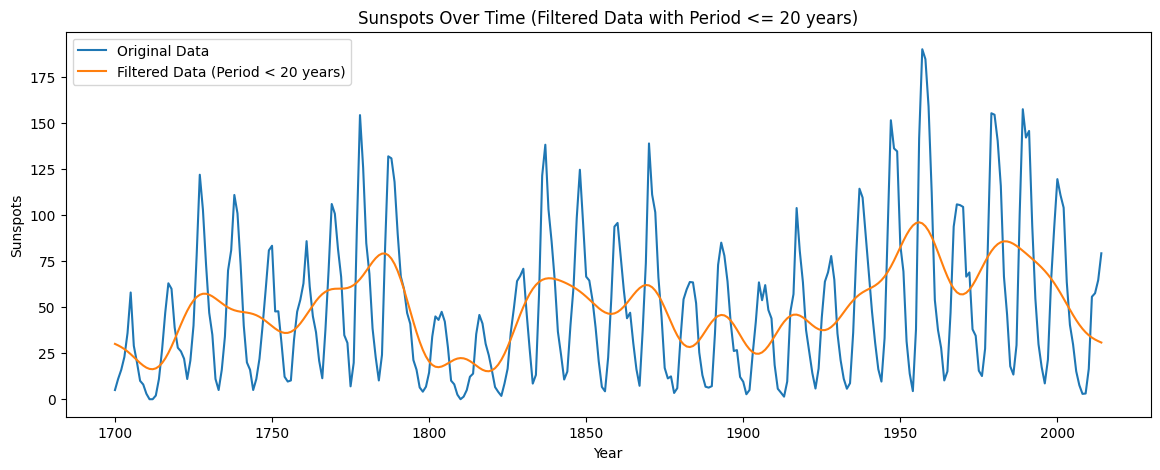

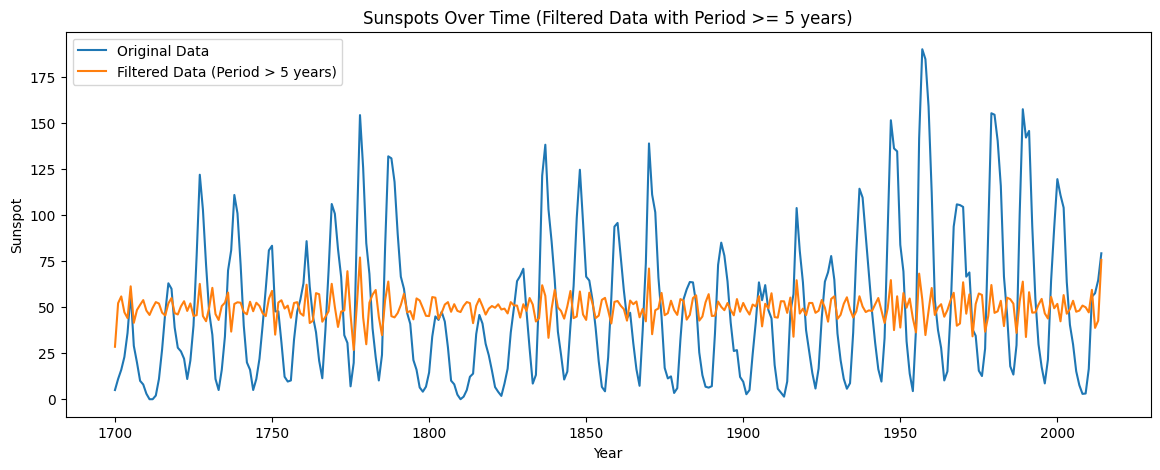

In [20]:
filtered_sunspots_above_5 = ifft(fft_values_below_5).real
filtered_sunspots_below_20 = ifft(fft_values_above_20).real

plt.plot(recorded_years, sunspot_counts, label="Original Data")
plt.plot(
    recorded_years,
    filtered_sunspots_below_20,
    label="Filtered Data (Period < 20 years)",
)
plt.xlabel("Year")
plt.ylabel("Sunspots")
plt.title("Sunspots Over Time (Filtered Data with Period <= 20 years)")
plt.legend()
plt.show()

plt.plot(recorded_years, sunspot_counts, label="Original Data")
plt.plot(
    recorded_years, filtered_sunspots_above_5, label="Filtered Data (Period > 5 years)"
)
plt.xlabel("Year")
plt.ylabel("Sunspot")
plt.title("Sunspots Over Time (Filtered Data with Period >= 5 years)")
plt.legend()
plt.show()


### (d)

Vergleichen Sie die Ergebnisse mit denen aus Aufgabe 1. Beschreiben und erklären Sie Unterschiede in den Fourier-Koeffizienten.

> TODO: answer / comparison

## Aufgabe 3

In dieser Aufgabe analysieren und bearbeiten Sie ein Musikstück (`music.wav`). Sie dürfen dafür zB die fft routine von `numpy` oder `scipy` sowie das `librosa` und `soundfile` paket verwenden.


### (a)

Plotten Sie die Wellenform des Klangs (waveplot) - einmal vollständig und einmal für einen kleinen Zeitberech, sodass die Wellenform deutlich wird - sowie das Amplitudenspektrum. Wieso ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

In [21]:
data, sr = librosa.load("./data/music.wav")
Audio(data, rate=sr)


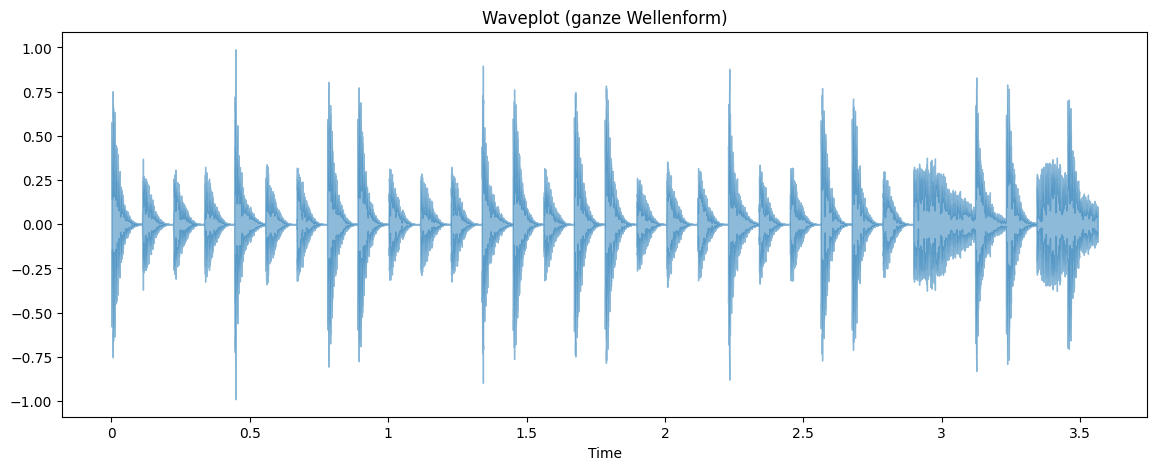

In [22]:
librosa.display.waveshow(data, sr=sr, alpha=.5)
plt.title("Waveplot (ganze Wellenform)")
plt.show()

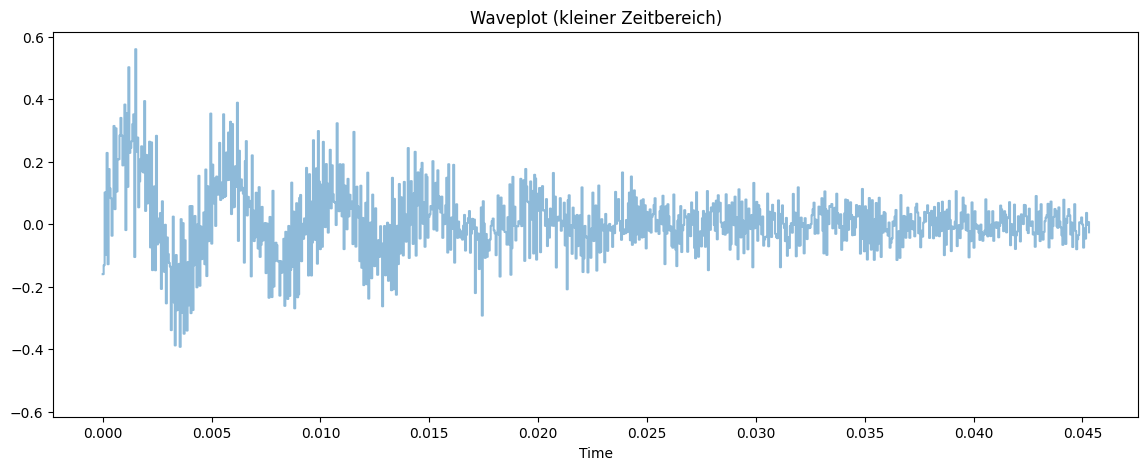

In [23]:
librosa.display.waveshow(data[10000:11000], sr=sr, alpha=.5)
plt.title("Waveplot (kleiner Zeitbereich)")
plt.show()

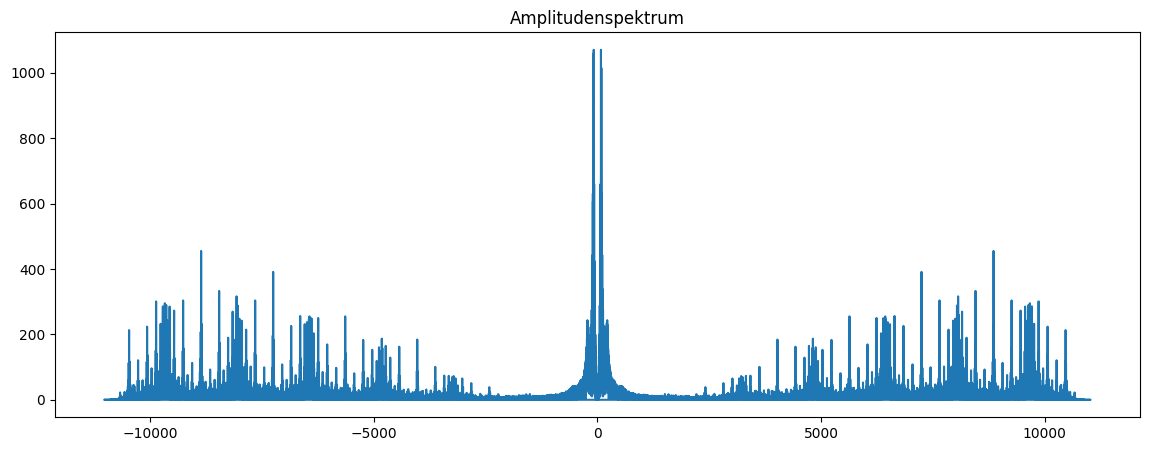

In [24]:
fft_result = fft(data)
frequencies = fftfreq(len(data), 1 / sr)

plt.plot(frequencies, np.abs(fft_result))
plt.title("Amplitudenspektrum")
plt.show()

#### Warum ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

Das Amplitudenspektrum ist symmetrisch bezüglich des Vorzeichens, weil die Fouriertransformation, die zur Berechnung des Amplitudenspektrums verwendet wird, reellwertige Funktionen in komplexe Funktionen umwandelt. Bei reellwertigen Funktionen ist der Realteil des Amplitudenspektrums gerade und der Imaginärteil ungerade. Das bedeutet, dass die Amplituden der positiven und negativen Frequenzkomponenten gleich sind, während die Phasen der negativen Frequenzkomponenten das negative Vorzeichen der Phasen der positiven Frequenzkomponenten haben.

Die Symmetrie des Amplitudenspektrums ist eine direkte Folge der Symmetrie der Fouriertransformation. Die Fouriertransformation einer reellwertigen Funktion $f(t)$ ist gegeben durch:

$$
F(\omega)=\int_{-\infty}^{\infty} f(t) e^{-i \omega t} d t
$$

Da $f(t)$ reellwertig ist, gilt:

$$
F(-\omega)=\int_{-\infty}^{\infty} f(t) e^{i \omega t} d t=F^*(\omega)
$$

Das bedeutet, dass das Amplitudenspektrum, das den Betrag der Fouriertransformierten darstellt, symmetrisch bezüglich des Vorzeichens ist:

$$
|F(-\omega)|=|F(\omega)|
$$

Source:

- [tuwien](https://ti.tuwien.ac.at/cps/teaching/courses/dspv/files/DFT-FFT.pdf)


### (b) 

Trennen Sie den Sound-Signal in einen Teil oberhalb und unterhalb von 2 kHz in Frequenzen. Identifizieren Sie jeweils die Top 5 Frequenzen in diesen Frequenzbereichen.


In [25]:
mask_below_2kHz = np.abs(frequencies) < 2000
mask_above_2kHz = np.abs(frequencies) >= 2000

# Filtern der Frequenzbereiche unter und über 2kHz
fft_below_2kHz = fft_result * mask_below_2kHz
fft_above_2kHz = fft_result * mask_above_2kHz

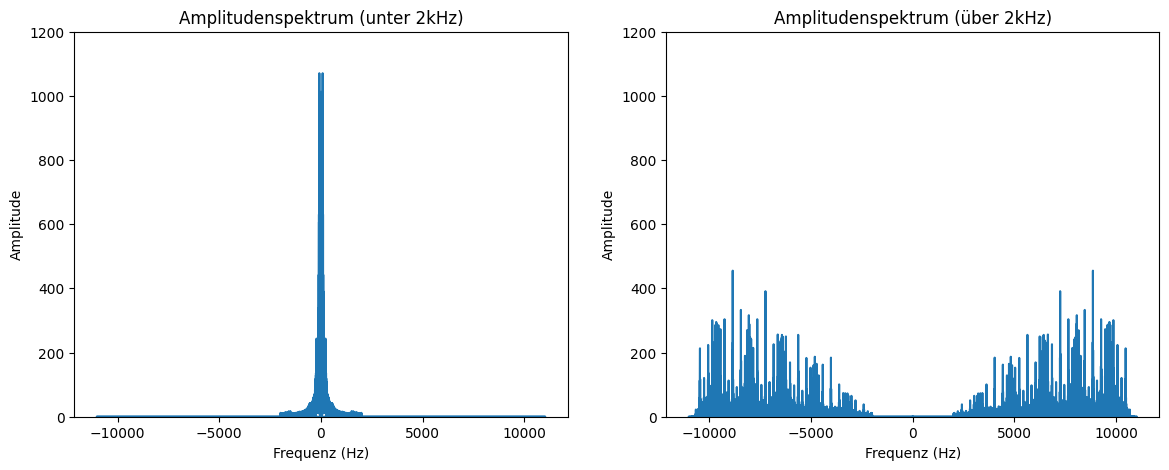

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(frequencies, np.abs(fft_below_2kHz))
ax1.set_title("Amplitudenspektrum (unter 2kHz)")
ax1.set_xlabel("Frequenz (Hz)")
ax1.set_ylabel("Amplitude")

ax2.plot(frequencies, np.abs(fft_above_2kHz))
ax2.set_title("Amplitudenspektrum (über 2kHz)")
ax2.set_xlabel("Frequenz (Hz)")
ax2.set_ylabel("Amplitude")

ax1.set_ylim([0, 1200])
ax2.set_ylim([0, 1200])

plt.show()

In [27]:
positive_frequencies_mask = frequencies >= 0

# Filter out negative frequencies
fft_below_2kHz_positive = fft_below_2kHz[positive_frequencies_mask]
fft_above_2kHz_positive = fft_above_2kHz[positive_frequencies_mask]

frequencies_positive = frequencies[positive_frequencies_mask]

# Identify the top 5 frequencies in these frequency ranges
top_5_freqs_below_2kHz_positive = np.argsort(np.abs(fft_below_2kHz_positive))[-5:]
top_5_freqs_above_2kHz_positive = np.argsort(np.abs(fft_above_2kHz_positive))[-5:]

In [28]:
def print_top_freqs(freqs):
    for freq in sorted(freqs):
        print(f"- {freq:.3f} Hz")

print("Top 5 Frequenzen unter 2kHz: ")
print_top_freqs(frequencies_positive[top_5_freqs_below_2kHz_positive])

print()
print("Top 5 Frequenzen über 2kHz: ")
print_top_freqs(frequencies_positive[top_5_freqs_above_2kHz_positive])

Top 5 Frequenzen unter 2kHz: 
- 71.829 Hz
- 80.807 Hz
- 81.930 Hz
- 89.786 Hz
- 90.908 Hz

Top 5 Frequenzen über 2kHz: 
- 7246.840 Hz
- 8064.733 Hz
- 8454.740 Hz
- 8857.373 Hz
- 9260.007 Hz


### (c)
Berechnen Sie aus diesen beiden Teilen jeweils eine Rekonstruktion. Berechnen Sie den Fehler der Rekonstruktion wie in Aufgabe 1 für die gefilterten Signale und schreiben Sie die gefilterten rekonstruierten Daten in eine wav-Datei. Beschreiben und erklären Sie das Ergebnis.


In [29]:
def plot_reconstruction(original, reconstructed, title):
    plt.plot(original, label="Original Signal")
    plt.plot(reconstructed, label="Reconstructed Signal")
    plt.title(title)
    plt.legend()
    plt.show()

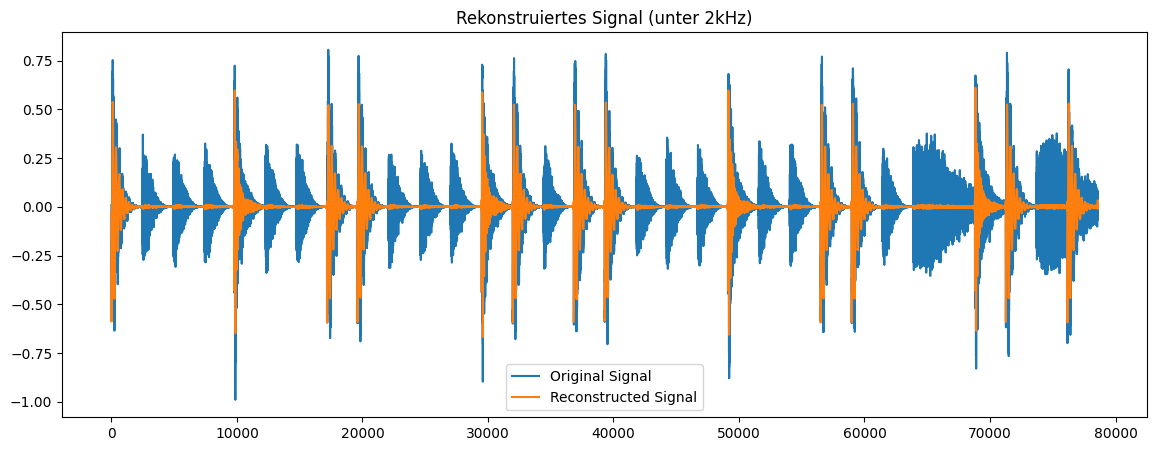

In [30]:
reconstructed_below_2kHz = ifft(fft_below_2kHz).real

plot_reconstruction(data, reconstructed_below_2kHz, "Rekonstruiertes Signal (unter 2kHz)")
Audio(data=reconstructed_below_2kHz, rate=sr)

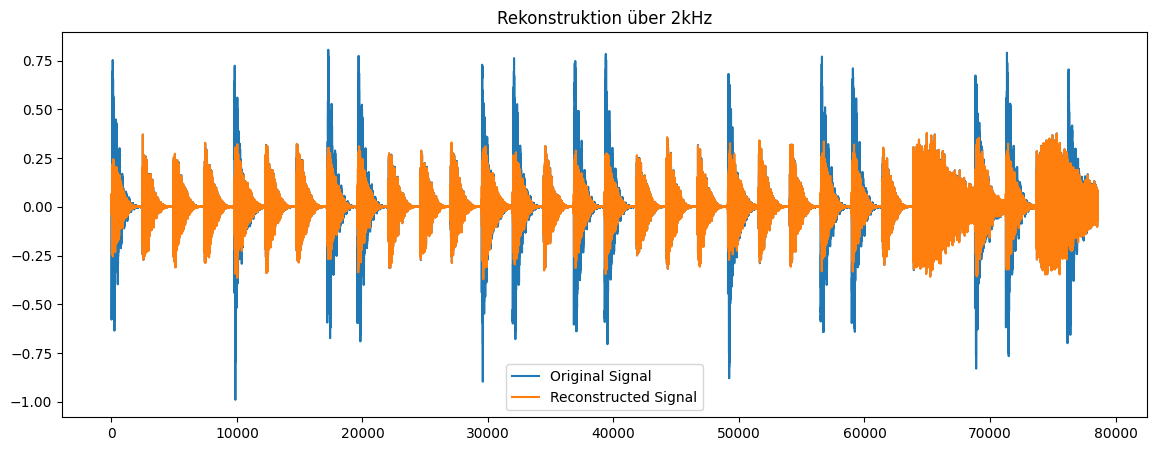

In [31]:
reconstructed_above_2kHz = ifft(fft_above_2kHz).real

plot_reconstruction(original=data, reconstructed=reconstructed_above_2kHz, title="Rekonstruktion über 2kHz")
Audio(data=reconstructed_above_2kHz, rate=sr)

In [32]:
error_below_2kHz = rel_error(data, reconstructed_below_2kHz)
error_above_2kHz = rel_error(data, reconstructed_above_2kHz)

print("Fehler der Rekonstruktion unter 2kHz: ", error_below_2kHz)
print("Fehler der Rekonstruktion über 2kHz: ", error_above_2kHz)

Fehler der Rekonstruktion unter 2kHz:  0.5783246
Fehler der Rekonstruktion über 2kHz:  0.81580657


In [33]:
sf.write("reconstructed_below_2kHz.wav", reconstructed_below_2kHz, sr)
sf.write("reconstructed_above_2kHz.wav", reconstructed_above_2kHz, sr)

## Aufgabe 4
In dieser Aufgabe analysieren und bearbeiten Sie eine Bilddatei (img.jpg). Sie dürfen dafür die fft
routine von numpy oder scipy verwenden.

In [34]:
def plot_image(img, title, cmap="viridis"):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()


def plot_spectrum(spectrum, title):    
    # https://www.perplexity.ai/search/7bae3a4c-96d4-4061-9833-289be445fd02?s=c
    plt.imshow(np.log1p(np.abs(spectrum)), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2))
    
    plt.title(title)
    plt.colorbar()
    plt.show()


# plot image and spectrum side by side
def plot_image_and_spectrum(img, spectrum, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(img)
    ax1.set_title("Rekonstruiertes Bild")

    ax2.imshow(np.abs(spectrum), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2), vmin=0, vmax=6)
    ax2.set_title("Spektrum")

    plt.suptitle(title)
    plt.show()


def filter_spectrum(spectrum, threshold):
    return spectrum * (np.abs(spectrum) > threshold)


def compress_and_reconstruct(img, threshold_percent):
    spectrum = fft2(img)
    spectrum_shifted = fftshift(spectrum)

    # Filtering
    threshold = threshold_percent * np.max(np.abs(spectrum_shifted))
    filtered_spectrum = filter_spectrum(spectrum_shifted, threshold)

    # Compression rate
    data_kept_percentage = np.sum(np.abs(filtered_spectrum)) / np.sum(np.abs(spectrum_shifted))

    # Inverse
    filtered_spectrum_unshifted = ifftshift(filtered_spectrum)
    img_reconstructed = ifft2(filtered_spectrum_unshifted).real

    return img_reconstructed, filtered_spectrum, rel_error(img, img_reconstructed), data_kept_percentage

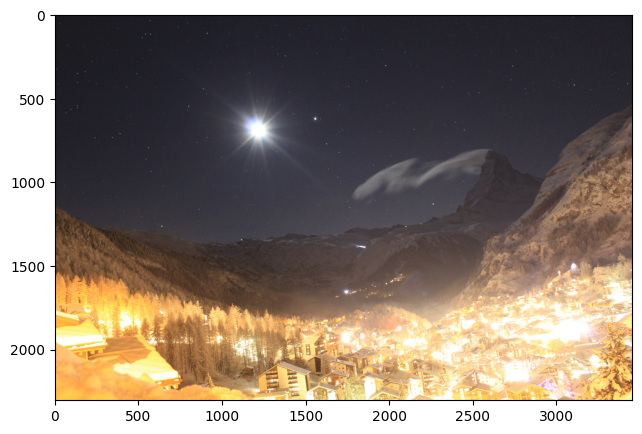

In [35]:
img_original = plt.imread("data/img.jpg")
plot_image(img_original, "")

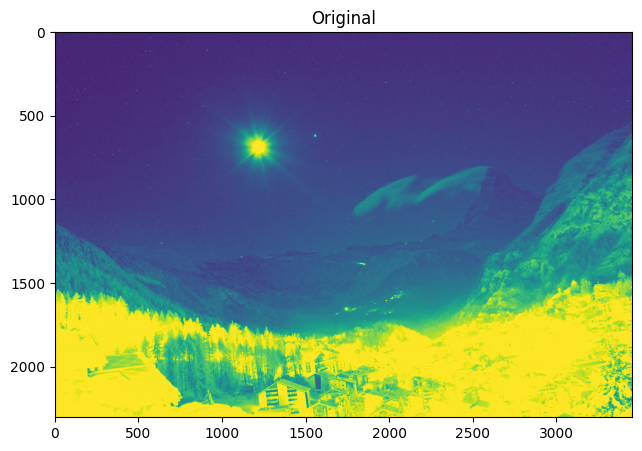

In [36]:
# greyscale 
#img = np.mean(img_original, axis=2)

# only keep red part
img = img_original[:,:,0] # RED part of RGB Image

plot_image(img, "Original")

### (a)
Plotten Sie die 2D-Verteilung der absoluten Werte der Fourier-Komponenten, sodass die kleinsten k-Werte in der Mitte liegen. Erklären Sie die Natur der Verteilung.

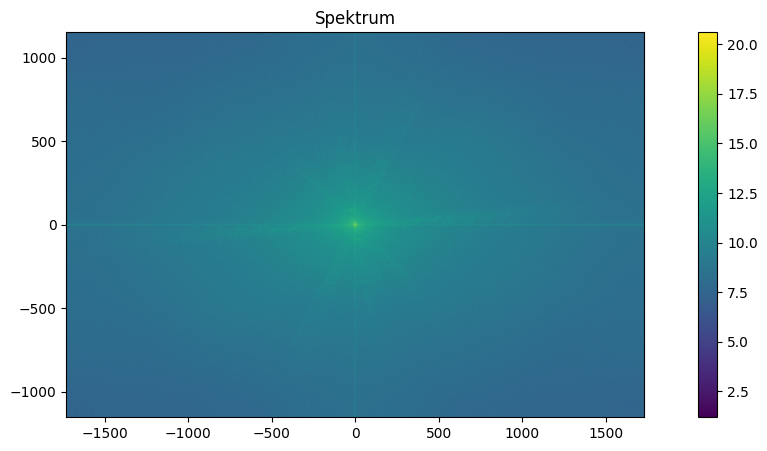

In [37]:
plot_spectrum(fftshift(fft2(img)), "Spektrum")

Die 2D-Verteilung der Fourier-Komponenten zeigt die verschiedenen Frequenzen, die im Bild vorhanden sind. In der Mitte des Plots befinden sich die niedrigen Frequenzen, die für glatte Übergänge und große, zusammenhängende Bereiche im Bild verantwortlich sind. Die hohen Frequenzen, die feine Details und Kanten repräsentieren, liegen an den Rändern des Plots. 

Die Farben im Plot zeigen die Amplitude oder Stärke jeder Frequenz an. Helle Farben deuten auf hohe Amplituden hin, was bedeutet, dass diese Frequenzen einen großen Beitrag zur Bildinformation leisten. Dunkle Farben weisen auf niedrige Amplituden hin, was darauf hindeutet, dass diese Frequenzen einen geringeren Beitrag zur Bildinformation leisten. 

Insgesamt zeigt der Plot, dass die meisten Informationen in natürlichen Bildern in den niedrigen Frequenzen konzentriert sind, während die hohen Frequenzen weniger Energie enthalten.

### (b)
Entfernen Sie je die Fourier-Komponenten mit absoluter Amplitude unter dem Schwellenwert 0.001%, 0.01%, 0.1%, 1% und 10% der maximalen Amplitude. Führen Sie eine inverse Fourier-Transformation durch und stellen Sie die gefilterten Fourierkomponenten sowie die resultierenden Bilder dar. Beschreiben und erklären Sie die Unterschiede.

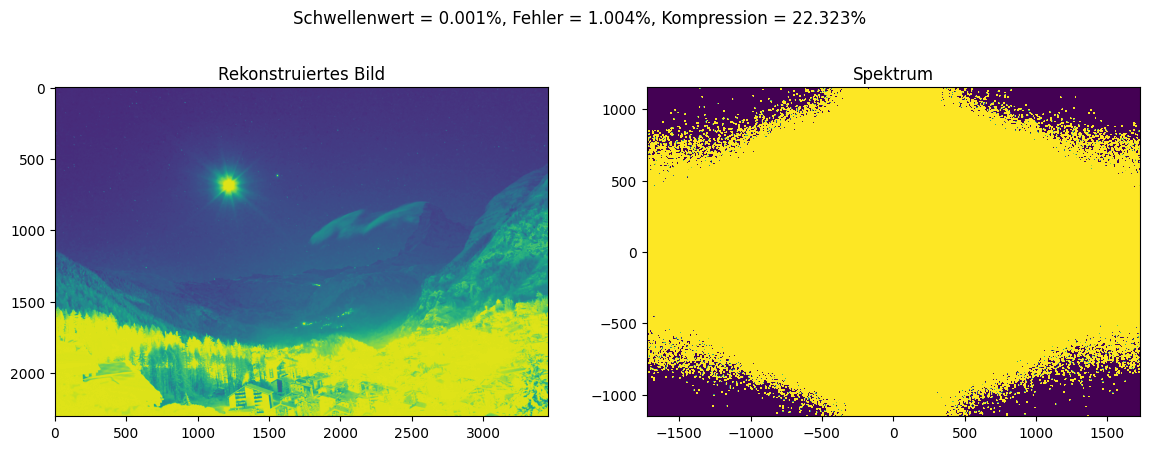

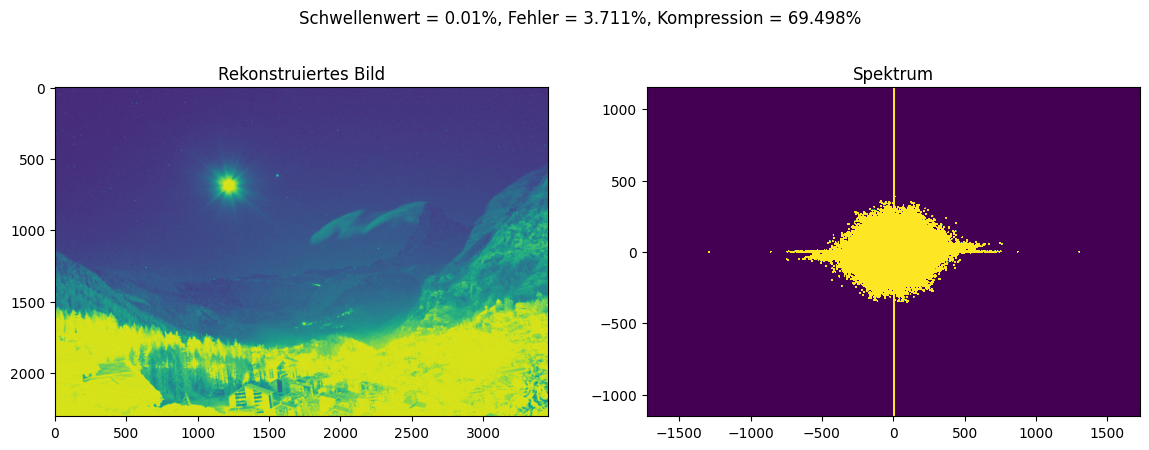

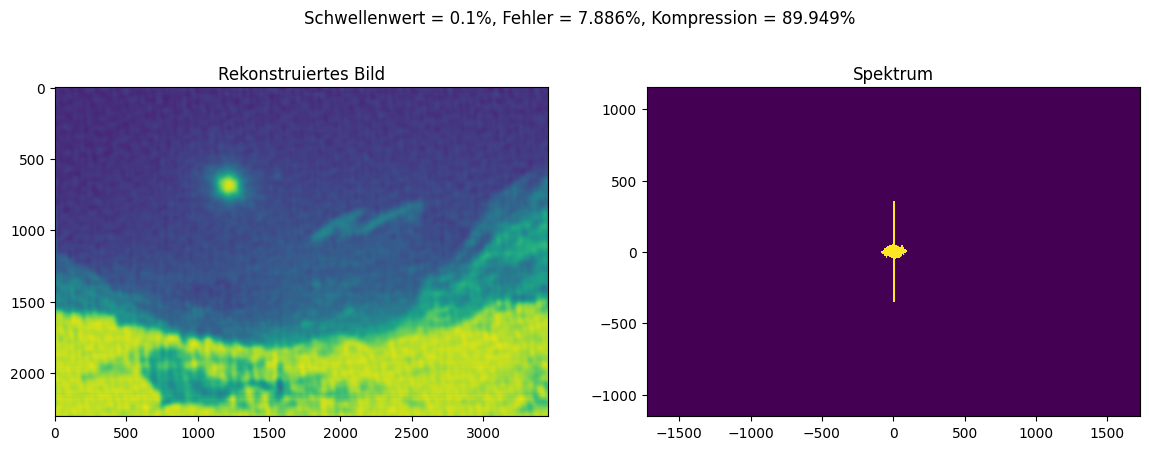

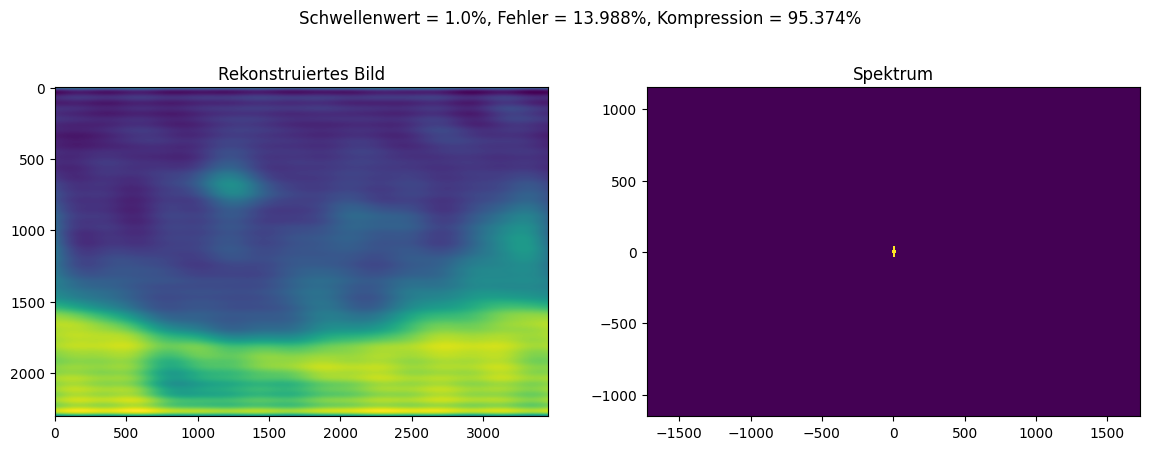

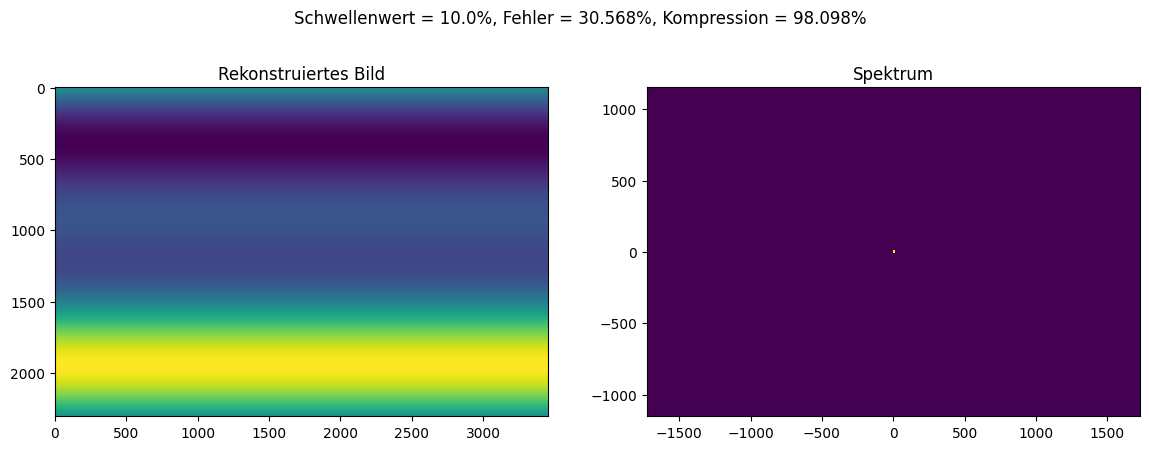

In [38]:
for threshold in [.00001, .0001, .001, .01, .1]:
    img_reconstructed, filtered_spectrum, error, data_kept = compress_and_reconstruct(
        img, threshold
    )

    plot_image_and_spectrum(
        img_reconstructed,
        filtered_spectrum,
        f"Schwellenwert = {threshold*100}%, Fehler = {error*100:.3f}%, Kompression = {(1-data_kept)*100:.3f}%",
    )

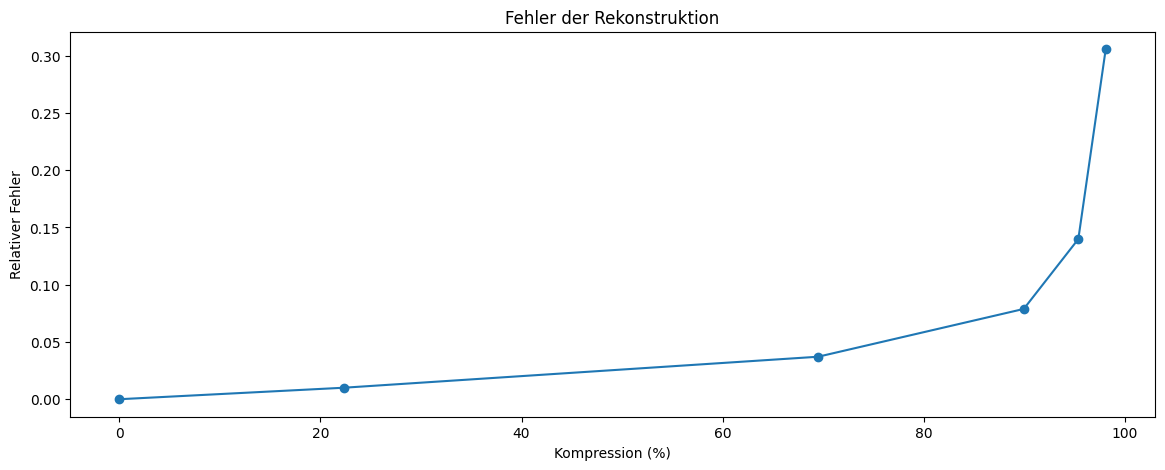

In [39]:
# thresholds = np.linspace(0, 1, 100)
thresholds = [0.e+00, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]

errors = []
compressions = np.array([])
for threshold in thresholds:
    img_reconstructed, _, error, data_kept = compress_and_reconstruct(img, threshold)
    compressions = np.append(compressions, 1-data_kept)
    errors.append(error)

plt.plot(compressions * 100, errors, marker='o')
plt.xlabel("Kompression (%)")
plt.ylabel("Relativer Fehler")
plt.title("Fehler der Rekonstruktion")
plt.show()

Je höher der Schwellenwert für die gefilterten Fourierkomponenten ist, desto mehr Komponenten werden aus dem Spektrum entfernt. Das bedeutet, dass weniger Frequenzen im rekonstruierten Bild enthalten sind, was zu einer Verringerung der Bildqualität führt. Mit einem höheren Schwellenwert werden mehr hohe Frequenzen entfernt, die für die feinen Details und Kanten im Bild verantwortlich sind. Daher wird das Bild mit zunehmendem Schwellenwert immer verschwommener und verliert mehr Details.

Der Schwellenwert ist ein Grenzwert, der dazu dient, Fourier-Komponenten auf der Grundlage ihrer Amplitude auszuwählen. Fourier-Komponenten mit einer Amplitude unterhalb des Schwellenwertes werden aus dem Spektrum entfernt, während Komponenten mit einer Amplitude oberhalb des Schwellenwertes beibehalten werden. Durch die Auswahl eines Schwellenwertes kann die Menge an Informationen, die im Bild gespeichert werden, reduziert werden, wodurch das Bild komprimiert wird. Je höher der Schwellenwert, desto stärker wird das Bild komprimiert.

### (c)
Berechnen Sie den Fehler (Aufgabe 1) zwischen rekonstruiertem und Originalbild. Wie weit können die Daten kompressiert werden, ohne einen Fehler von höchstens 1% zu überschreiten?

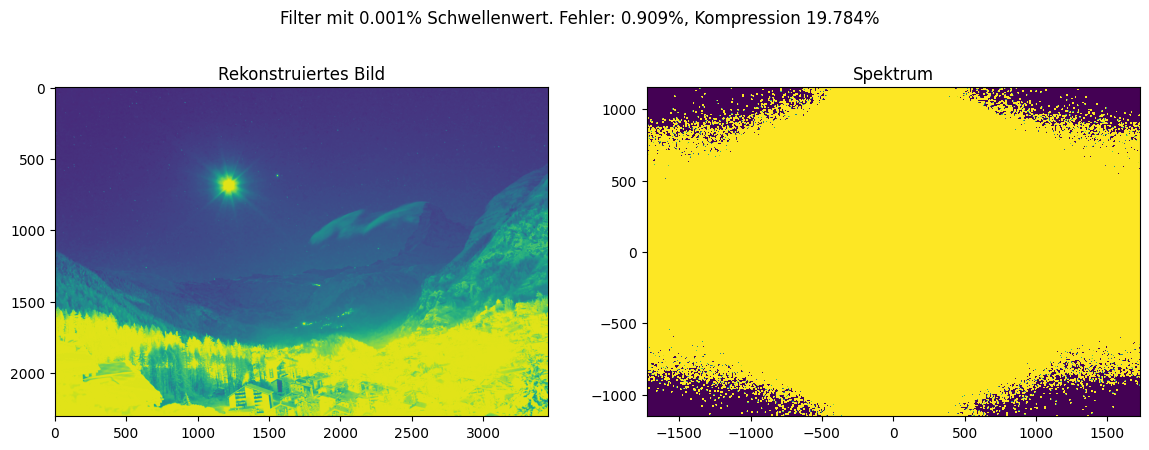

Maximum compression without exceeding 1% relative error is 19.784379%


In [40]:
threshold, max_compression = 0, 0
step_size = 0.000001

while threshold <= 1:
    _, _, error, data_kept = compress_and_reconstruct(img, threshold)
    if error <= 0.01:  # 0.01 entspricht einem relativen Fehler von 1%
        max_compression = 1 - data_kept
        threshold += step_size
    else:
        break


img_reconstructed, filtered_spectrum, error, data_kept = compress_and_reconstruct(
    img, threshold - step_size
)

plot_image_and_spectrum(
    img_reconstructed,
    filtered_spectrum,
    f"Filter mit {threshold*100}% Schwellenwert. Fehler: {error*100:.3f}%, Kompression {max_compression*100:.3f}%",
)

print(f"Maximum compression without exceeding 1% relative error is {max_compression*100:.6f}%")

## Zusammenfassung


## Lerntagebuch


### KW 18


### KW 19

#### Darstellungsformen der Fourier-Serie
TODO


### KW20
#### Interpretation Negativer Frequenzen

Wir haben beim erarbeiten der `Aufgabe 3` einige Verständnisfragen geklärt. Dabei war nicht ganz klar ob der low- resp. high-pass filter auf das absolute oder nicht-absolute Frequenzspektrum angewandt werden sollte. In diesem Zusammenhang haben wir uns die Frage gestellt, welche Bedeutung die negativen Frequenzen haben:

Die Fourier-Transformation teilt ein Signal nicht in Sinuswellen, sondern in komplexe Exponentialfunktionen (auch "komplexe Sinuswellen" oder "cisoids" genannt) auf. Diese können als Spiralen im komplexen Raum dargestellt werden, die entweder links- oder rechtshändig (im Uhrzeigersinn oder gegen den Uhrzeigersinn) rotieren. Das Konzept der negativen Frequenz ergibt sich aus der Drehrichtung dieser Spiralen.

Bei realen Signalen gibt es immer zwei komplexe Exponentialfunktionen mit gleicher Amplitude, die in entgegengesetzten Richtungen rotieren. Ihre realen Teile kombinieren sich und ihre imaginären Teile heben sich auf, was ein reales Sinussignal hinterlässt. Daher hat das Spektrum einer Sinuswelle immer zwei Spitzen, eine mit positiver und eine mit negativer Frequenz.

Die negativen und positiven Frequenzkomponenten sind beide notwendig, um das reale Signal zu erzeugen. Wenn allerdings bereits bekannt ist, dass es sich um ein reales Signal handelt, bietet die andere Seite des Spektrums keine zusätzlichen Informationen und wird daher oft vernachlässigt. Im allgemeinen Fall komplexer Signale sind jedoch beide Seiten des Frequenzspektrums notwendig.

![](https://i.stack.imgur.com/eCpbp.gif)

Die Fourier-Transformation nutzt sowohl positive als auch negative Frequenzen, um ein reales Signal korrekt zu rekonstruieren. Die Realteile der komplexen Exponentialfunktionen kombinieren sich, während die Imaginärteile sich aufheben, um das ursprüngliche Signal zu erzeugen. Die Verwendung nur einer Seite des Spektrums würde zu einem komplexen Signal führen. Obwohl die andere Seite als redundant betrachtet werden kann, ist sie unerlässlich für die korrekte Rekonstruktion des Signals.

Referenz:
- [What is the physical significance of negative frequencies? - StackExchange](https://dsp.stackexchange.com/questions/431/what-is-the-physical-significance-of-negative-frequencies)
- [Is the negative spectrum (by DFT) of a real signal "needed" to reconstruct it? - StackExchange](https://dsp.stackexchange.com/questions/84769/is-the-negative-spectrum-by-dft-of-a-real-signal-needed-to-reconstruct-it)


### KW21
#### Order matters
Bei Aufgabe 2.c haben wir festgestellt, dass die Reihenfolge in welcher wir Komponenten entfernen wichtig ist, da sonst die Aufgabe nicht sauber erfüllt ist. 

### KW22
#### Relative Error
Wir haben uns den relative error genauer angeschaut und herausgefunden, dass der RRMSE falsch implementiert wurde. Ebenfalls haben wir haben mit sum of coefficients herumgespielt, da dies angeblich auch eine angemessene Variante ist den Fehler zu bestimmen. 

#### Fragen an Stefan
- Ist unsere relative error funktion richtig implementiert? 
- Negative Sunspots nach IFFT (k<20 ist gut, aber k>5 nicht)


#### Antworten
- Grund für die negativen Sunspots war, dass wir die Nullfrequenz entfernt haben, welche essentiell ist, um die Basislinie zu definieren. Sobald diese entfernt wird (wie bei k>5 zuerst der Fall) führt das dazu, dass das ganze Signal verschoben wird. Das inkludieren der Nullfrequenz löste das Problem.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c921941-9604-4099-90d4-1d4be742febc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>